In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/Alphabet_keys.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier_updated3.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier3.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 26

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
def augment_keypoints(keypoints, labels, num_augmented=2):
    """Create augmented versions of keypoints with small noise"""
    augmented_data = []
    augmented_labels = []
    
    for i, sample in enumerate(keypoints):
        label = labels[i]  # Use the passed labels parameter instead of y_dataset
        # Add original
        augmented_data.append(sample)
        augmented_labels.append(label)
        
        # Create augmented versions
        for _ in range(num_augmented):
            # Add small random noise to coordinates
            noise = np.random.normal(0, 0.03, sample.shape)  # Small Gaussian noise
            augmented = sample + noise
            augmented_data.append(augmented)
            augmented_labels.append(label)
    
    return np.array(augmented_data), np.array(augmented_labels)

X_train_raw, X_test, y_train_raw, y_test = train_test_split(
    X_dataset, y_dataset, test_size=0.2, random_state=RANDOM_SEED
)

# Further split training into train and validation
X_train_base, X_val, y_train_base, y_val = train_test_split(
    X_train_raw, y_train_raw, test_size=0.2, random_state=RANDOM_SEED
)

# Augment only the actual training data
X_train, y_train = augment_keypoints(X_train_base, y_train_base, num_augmented=2)


# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),  # Increased dropout
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 26)             │           858 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,594 (68.73 KB)

 Trainable params: 17,146 (66.98 KB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
from tensorflow.keras.callbacks import  ReduceLROnPlateau
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',      # Metric to monitor
    factor=0.5,              # Reduce LR by this factor
    patience=5,              # Epochs with no improvement to wait
    min_lr=1e-6,             # Minimum LR
    verbose=1                # Print updates
)

In [11]:
# Model compilation
model.compile(
    optimizer='adamW',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_val, y_val),  # Validation set for tuning
    callbacks=[cp_callback, es_callback, reduce_lr_callback]
)

Epoch 1/200
750/753 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4256 - loss: 2.1686
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier_updated3.keras
753/753 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4266 - loss: 2.1647 - val_accuracy: 0.9534 - val_loss: 0.3675 - learning_rate: 0.0010
Epoch 2/200
740/753 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8605 - loss: 0.6017
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier_updated3.keras
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8609 - loss: 0.6003 - val_accuracy: 0.9806 - val_loss: 0.2123 - learning_rate: 0.0010
Epoch 3/200
737/753 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9235 - loss: 0.3733
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier_updated3.keras
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9236 - loss: 0.3728 - val_accuracy: 0.9928 - val_loss: 0.1603 - learning_rate: 0.0010
Epoch 4/200
752/753 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc

In [13]:
# Model evaluation
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9988 - loss: 0.0259
Test accuracy: 0.9986


In [14]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [15]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
[1.43289265e-08 1.49654276e-20 7.17737586e-19 8.89951768e-15
 2.76250485e-12 2.57538283e-17 2.08643547e-10 4.25799459e-17
 7.70592411e-13 3.47276582e-11 9.28012008e-12 8.57497973e-17
 1.35851790e-12 4.67311303e-13 1.68136209e-14 8.03691542e-15
 1.11975528e-14 4.49809541e-16 3.66901258e-12 1.00000000e+00
 1.33691386e-14 1.13767841e-16 2.65632470e-16 1.02031783e-09
 4.30910434e-18 1.91416808e-14]
19


# Confusion matrix

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


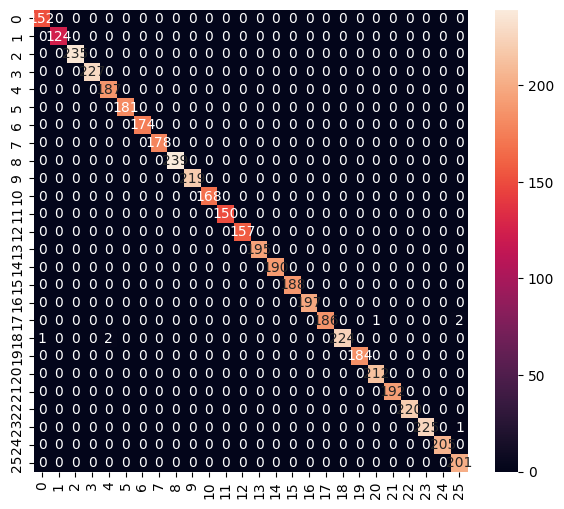

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       152
           1       1.00      1.00      1.00       124
           2       1.00      1.00      1.00       235
           3       1.00      1.00      1.00       227
           4       0.99      1.00      0.99       187
           5       1.00      1.00      1.00       181
           6       1.00      1.00      1.00       174
           7       1.00      1.00      1.00       178
           8       1.00      1.00      1.00       239
           9       1.00      1.00      1.00       219
          10       1.00      1.00      1.00       168
          11       1.00      1.00      1.00       150
          12       1.00      1.00      1.00       157
          13       1.00      1.00      1.00       195
          14       1.00      1.00      1.00       190
          15       1.00      1.00      1.00       188
          16       1.00      1.00      1.00       197
     

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [17]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [18]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ARAVIN~1\AppData\Local\Temp\tmplhyw4hat\assets


INFO:tensorflow:Assets written to: C:\Users\ARAVIN~1\AppData\Local\Temp\tmplhyw4hat\assets


Saved artifact at 'C:\Users\ARAVIN~1\AppData\Local\Temp\tmplhyw4hat'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  2080884498496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2080759183136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2080805505152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2080800593168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2080805566944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2080805503040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2080884626176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2080800375728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2080798524160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2080798525216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20807984979

25488

# Inference test

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

c:\Softwares\All Programs\New\venv\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [20]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [21]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 8.57 ms


In [23]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.49810262e-08 1.40119226e-20 6.93889918e-19 9.16081718e-15
 2.60185341e-12 2.56530297e-17 2.22186339e-10 4.34111400e-17
 7.85425273e-13 3.63506378e-11 1.04834709e-11 8.30196579e-17
 1.41277777e-12 4.47860038e-13 1.66921005e-14 8.19880629e-15
 1.05874045e-14 4.29171927e-16 3.47327419e-12 1.00000000e+00
 1.34538597e-14 1.26078988e-16 2.53056678e-16 9.25278631e-10
 4.48679721e-18 1.80855798e-14]
19
